In [1]:
import glob
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from matplotlib import animation
from scipy.interpolate import Rbf
import pandas as pd
import numba as nb


# Read the data and variables From Full dataset

In [2]:
path2016 = "data/jason3/2016/*.nc/*.nc"
#path2021 = "data/jason3/2021/*.nc/*.nc"
#path2018 = "data/jason3/2018/*.nc/*.nc"
#outputFile = "reduced_caspian_2018.csv"

files = glob.glob(path2016)
ncid = []

for i, file in enumerate(files):
    ncid.append(nc.Dataset(file))


In [3]:
def read_variable_data(ncid, varname):
    row = []
    try:
        for x in range(len(ncid)):
            if "CF-1.7" in ncid[x].Conventions:
                if "range_ocean" in varname or "ssha" in varname:
                    row.append(ncid[x].groups["data_01"].groups["ku"].variables[varname])
                else:
                    row.append(ncid[x].groups["data_01"].variables[varname])
            else:
                row.append(ncid[x].variables[varname])
            ## Case for 2021 data, else case for 2016 data
            #if ncid[x].variables == {}:
            #    row.append(ncid[x].groups["data_01"].variables[varname])
            #else:
    except KeyError as e:
        print("KeyError" + str(e), len(row), ncid[x].variables)
    return row

def read_pass_number(ncid, convention="1.1", varname="lat"):
    row = []
    for x in range(len(ncid)):
        try:
            if "1.1" in convention:
                ncid[x].variables[varname]
                row.append(ncid[x].pass_number)
                
            else:
                row.append(ncid[x].pass_number)

        except KeyError as e:
            print("Read pass number error: ", e, len(row), x)
            return
    return row

## Optimized numpy attempt

In [4]:
# Read variable Data CF-1.1 Convention

latList = read_variable_data(ncid, "lat")
lonList = read_variable_data(ncid, "lon")

meanSeaSurfaceList = read_variable_data(ncid, "mean_sea_surface")
timeList = read_variable_data(ncid, "time")
surfaceTypeList = read_variable_data(ncid, "surface_type")
rangeList = read_variable_data(ncid, "range_ku")
sshaList = read_variable_data(ncid, "ssha")
altitudeList = read_variable_data(ncid, "alt")

bathymetryList = read_variable_data(ncid, "bathymetry")
geoflagsList = read_variable_data(ncid, "geophysical_quality_flag")
qualityFlagList = read_variable_data(ncid, "alt_quality_flag")
passNumberList = read_pass_number(ncid)

#dataLists = [latList, lonList, meanSeaSurfaceList, timeList, surfaceTypeList, sshaList,bathymetryList,rangeList,altitudeList, geoflagsList, qualityFlagList]
#dataListsNames = ["lat", "lon", "mss", "time", "surface type", "ssha", "elevation", "range","altitude", "geophysical quality flag", "alt quality flag", "pass number"]

dataLists = [latList, lonList, timeList, meanSeaSurfaceList, surfaceTypeList, rangeList,altitudeList, geoflagsList]
dataListsNames = ["lat", "lon", "time", "mss","surface type", "range","altitude", "geophysical quality flag", "pass number"]


latMin = 36.0
latMax = 48.0
lonMin = 46.0
lonMax = 55.0

height = len(dataLists)
width = 15000
print(height, width, len(dataLists[0]))

8 15000 2304


In [9]:
# Read variable Data CF-1.7 Convention

latList = read_variable_data(ncid, "latitude")
lonList = read_variable_data(ncid, "longitude")

meanSeaSurfaceList = read_variable_data(ncid, "mean_sea_surface_cnescls")
timeList = read_variable_data(ncid, "time")
surfaceTypeList = read_variable_data(ncid, "surface_classification_flag")
rangeList = read_variable_data(ncid, "range_ocean")
sshaList = read_variable_data(ncid, "ssha")
altitudeList = read_variable_data(ncid, "altitude")

bathymetryList = read_variable_data(ncid, "depth_or_elevation")
geoflagsList = read_variable_data(ncid, "geo_qual")
#qualityFlagList = read_variable_data(ncid, "alt_qual")
passNumberList = read_pass_number(ncid, convention="1.7", varname="latitude")

dataLists = [latList, lonList, timeList, meanSeaSurfaceList, surfaceTypeList, rangeList,altitudeList, geoflagsList]
dataListsNames = ["lat", "lon", "time", "mss","surface type", "range","altitude", "geophysical quality flag", "pass number"]


latMin = 36.0
latMax = 48.0
lonMin = 46.0
lonMax = 55.0

height = len(dataLists)
width = 14500
print(height, width, len(dataLists[0]))

8 14500 4347


In [5]:
def pad(arr):
    if width - len(arr) < 0:
        print(len(arr))
    return np.pad(arr, (0, width - len(arr)), mode='constant',constant_values=(np.nan,))

vectors = []
orbitPassesMat = np.full([len(dataLists[0]), width, ], np.nan)


for i, data in enumerate(dataLists):
    print("data type: {}, {} of {}".format(dataListsNames[i], i + 1, len(dataLists)))
    tempMat = np.full([len(data), width, ], np.nan)
    for x in range(len(data)):
        # should cover reading pass number list as this is not a nested list. Otherwise read nested using x as index        
        if (i == 0):
            orbitPass = passNumberList[x]
            orbitPassesMat[x,:] = orbitPass
            
        arr = np.array(data[x])
         #   len(data[x])
        #except:
            #
        
        arr = arr.astype(np.float32)
        entries = pad(arr)
        tempMat[x,:] = entries
    
    tempVector = tempMat.flatten()
    vectors.append(tempVector)
    
    if ( i == len(dataLists) - 1):
        orbitPasses = orbitPassesMat.flatten()
        vectors.append(orbitPasses)

data type: lat, 1 of 8
data type: lon, 2 of 8
data type: time, 3 of 8
data type: mss, 4 of 8
data type: surface type, 5 of 8
data type: range, 6 of 8
data type: altitude, 7 of 8
data type: geophysical quality flag, 8 of 8


In [6]:
# Rotate matrix and convert to pandas dataframe
dataMat = np.array(vectors)
print(dataMat.shape)
dataMat = np.transpose(dataMat)

print(dataMat.shape)

df = pd.DataFrame(dataMat)
df.columns = dataListsNames

(9, 34560000)
(34560000, 9)


In [7]:
df = df.drop(df[(df.lon > lonMax)].index)
df = df.drop(df[(df.lon < lonMin)].index)



In [8]:
df = df.drop(df[(df.lat > latMax)].index)
df = df.drop(df[(df.lat < latMin)].index)

In [9]:
df = df.dropna()

In [10]:

df["day"] = ""
df["month"] = ""
df["year"] = ""

base_date = datetime(2000, 1, 1)
print("Day")
df["day"] = df["time"].apply(lambda x: (base_date + timedelta(seconds=int(x))).day)
print("Month")
df["month"] = df["time"].apply(lambda x: (base_date + timedelta(seconds=int(x))).month)
print("Year")
df["year"] = df["time"].apply(lambda x: (base_date + timedelta(seconds=int(x))).year)


Day
Month
Year


In [11]:
df.head(100)

,lat,lon,time,mss,surface type,range,altitude,geophysical quality flag,pass number,day,month,year
210758,47.976856,47.871407,524148160.0,-10.8077,3.0,2.147484e+09,1348767.750,127.0,167.0,10,8,2016
210759,47.933575,47.916084,524148160.0,-10.8722,3.0,1.348771e+06,1348754.125,127.0,167.0,10,8,2016
210760,47.890270,47.960678,524148160.0,-10.8556,3.0,2.147484e+09,1348740.375,127.0,167.0,10,8,2016
210761,47.846947,48.005192,524148160.0,-10.8258,3.0,2.147484e+09,1348726.625,127.0,167.0,10,8,2016
210762,47.803604,48.049622,524148160.0,-10.7919,3.0,2.147484e+09,1348712.875,127.0,167.0,10,8,2016
...,...,...,...,...,...,...,...,...,...,...,...,...
210853,43.829613,51.737980,524148256.0,-11.3185,3.0,2.147484e+09,1347454.000,127.0,167.0,10,8,2016
210854,43.784603,51.775894,524148256.0,-11.3950,3.0,2.147484e+09,1347439.750,127.0,167.0,10,8,2016
210855,43.739578,51.813747,524148256.0,-11.4572,3.0,2.147484e+09,1347425.625,127.0,167.0,10,8,2016
210856,43.694534,51.851536,524148256.0,-11.4611,3.0,2.147484e+09,1347411.375,127.0,167.0,10,8,2016


In [12]:
df.to_csv(r'reduced_caspian_2016.csv', index=False)


In [13]:
data = df.loc[(df.month == 12) &(df.year == 2016) & (df["surface type"] == 1)]
data.head(10000)


,lat,lon,time,mss,surface type,range,altitude,geophysical quality flag,pass number,day,month,year
21210876,39.601505,49.333790,533916224.0,-33.217701,1.0,1346200.375,1346160.125,127.0,15.0,1,12,2016
21210877,39.555206,49.366535,533916224.0,-35.050701,1.0,1346186.625,1346146.250,127.0,15.0,1,12,2016
21210878,39.508896,49.399235,533916224.0,-35.988899,1.0,1346172.750,1346132.375,127.0,15.0,1,12,2016
21210879,39.462574,49.431885,533916224.0,-36.515499,1.0,1346159.000,1346118.500,127.0,15.0,1,12,2016
21210880,39.416241,49.464485,533916224.0,-36.713799,1.0,1346145.125,1346104.625,127.0,15.0,1,12,2016
...,...,...,...,...,...,...,...,...,...,...,...,...
26870851,41.242516,53.917706,536538624.0,-38.592800,1.0,1346791.125,1346748.250,127.0,29.0,31,12,2016
26870852,41.288349,53.952335,536538624.0,-38.693401,1.0,1346805.375,1346762.375,127.0,29.0,31,12,2016
26870853,41.334164,53.987019,536538624.0,-38.666698,1.0,1346819.500,1346776.500,127.0,29.0,31,12,2016
26870854,41.379971,54.021755,536538624.0,-39.100601,1.0,1346833.750,1346790.750,127.0,29.0,31,12,2016


[ 15.  29.  56.  91. 105. 132. 167. 207. 243. 208.  30.]


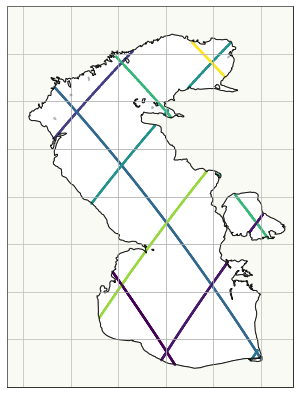

In [14]:
import cartopy.crs as crs
import cartopy.feature as feat

def windowToAxes(window):
    return [window[0]['lon'], window[1]['lon'], window[1]['lat'], window[0]['lat']]

window = [{'lat': latMax, 'lon': lonMax}, {'lat': latMin, 'lon': lonMin}]

data = df.loc[(df.month == 12) & (df["surface type"] == 1)]


fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=crs.PlateCarree())
ax.set_extent(windowToAxes(window))
ax.add_feature(feat.LAND, zorder=100, edgecolor='k', alpha=0.3)
ax.coastlines()
ax.scatter(x=data["lon"], y=data["lat"], c=data["pass number"], s=2, transform=crs.PlateCarree(central_longitude=0))
ax.gridlines(draw_labels=False)

print(data["pass number"].unique())
